# Анализ оттока клиентов банка

<div class="alert alert-info"> <b>Описание проекта</b>

Даны данные, содержащий информацию о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов, Великий и Рыбинск. Необходимо проанализировать клиентов регионального банка и выделите сегменты клиентов, которые склонны уходить из банка.

Для выполнения поставленной задачи необходимо:
- Провести предобработку данных
- Провести исследовательский анализ данных:
    - Определить значимые признаки отточности (интервалы значений характеристик, которые связаны с повышенным оттоком)
    - Сравнить портреты типичных клиентов, которые склонны и не склонны уходить из банка
    - Провести корреляционный анализ
- Сформулировать и проверить статистические гипотезы:
    - Гипотеза "Средний доход тех клиентов, которые ушли  и тех, которые остались, одинаков"
    - Гипотеза "Средний балл кредитного скоринга тех клиентов, которые ушли и тех, которые остались, одинаков"
    - Гипотеза "Средний возраст тех клиентов, которые ушли и тех, которые остались, одинаков"
- Объединяя признаки отточности, сформировать сегменты и отобрать лучшие
- Написать рекомендации 
- Подготовить презентацию 

Презентация: https://drive.google.com/file/d/1dh2RjSTY5ZRtaWgtUEFGZui68LAVcwcl/view?usp=sharing

### Предобработка данных

#### 1. Загрузим библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as ps
import numpy as np
import math as mth
from scipy import stats
import seaborn as sb

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### 2. Загрузим данные

In [2]:
df = pd.read_csv('bank_scrooge.csv')
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


#### 3. Переименуем колонки

In [3]:
df.columns = ['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
                'products', 'credit_card', 'last_activity', 'salary', 'churn']

#### 4. Исследуем пропущенные значения и типы данных

In [4]:
def first_step(df):
    # Проверим наличие пропусков
    missing_values = df.isnull().sum()
    print("Пропущенные значения:", missing_values.sum())
    print(missing_values)
    if missing_values.sum() != 0:
        print(f"Доля пропущенных значений {missing_values.sum()/df['user_id'].count():.1%}")

    # Проверим наличие дубликатов
    duplicate_values = df.duplicated().sum()
    print("Количество полных дубликатов:", duplicate_values)
    if duplicate_values != 0:
        print(f"Доля дубликатов {duplicate_values/df['user_id'].count():.1%}")
    
    print(df.info())

In [5]:
first_step(df)

Пропущенные значения: 2321
user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
salary              0
churn               0
dtype: int64
Доля пропущенных значений 23.2%
Количество полных дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int6

<div class="alert alert-info"> В данных достаточно много пропущенных значений (почти четверть от общего количества). Посмотрим на пропуски отдельно для каждой переменной: в переменной age всего 26 пропусков (менее 0.5%), можем удалить эти пропуски; в переменной balance уже намного больше пропусков и просто удалить их мы не можем. При этом заменить их медианной/средним значением или нулем тоже кажется нецелесообразным, поэтому пока оставим эти пропуски.

У переменных credit_card, last_activity и churn сразу поменяем тип данных на boolean, а у age на integer.

In [6]:
df = df.dropna(subset=['age'])

In [7]:
df['credit_card'] = df['credit_card'].astype(bool)
df['last_activity'] = df['last_activity'].astype(bool)
df['churn'] = df['churn'].astype(bool)
df['age'] = df['age'].astype(int)

#### 5. Исследуем дубликаты

In [8]:
duplicates = df[df['user_id'].duplicated()]
print(f"Доля дубликатов в user_id: {duplicates['user_id'].count()/df['user_id'].count():.1%}")

duplicates_all = df[df['user_id'].duplicated(keep=False)]

duplicates_all = duplicates_all.sort_values(by='user_id')
duplicates_all

Доля дубликатов в user_id: 0.5%


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
1893,116540,883.0,Рыбинск,Ж,55,1,362756.49,3,False,True,175920.48,True
7694,116540,887.0,Ярославль,Ж,38,0,NaN,1,False,True,119247.61,False
4866,117943,855.0,Рыбинск,Ж,32,6,1036832.93,4,True,True,107792.71,True
7542,117943,880.0,Ярославль,Ж,40,0,NaN,1,True,False,137718.93,False
5863,120258,908.0,Рыбинск,Ж,38,4,2213581.63,2,False,True,160327.77,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2302,220816,934.0,Рыбинск,Ж,74,5,1294285.39,3,True,False,95606.80,False
2597,226719,990.0,Ярославль,М,37,4,14648692.14,2,False,False,934412.61,True
4216,226719,903.0,Рыбинск,Ж,63,0,NaN,1,True,False,138582.58,False
8205,227795,840.0,Рыбинск,М,34,2,350768.03,1,True,False,102036.14,True


<div class="alert alert-info"> По одному и тому же человеку (среди дубликатов) могут быть совершенно разные данные, но так как доля дубликатов в user_id небольшая, удалим их.

In [9]:
df = df.drop_duplicates(subset='user_id')

In [10]:
df_shape = df.shape[0]

#### 6. Проведем кодирование переменных 

In [11]:
df_dummies = pd.get_dummies(df, columns=['gender'], drop_first=True)
df_dummies.head()

,user_id,score,city,age,equity,balance,products,credit_card,last_activity,salary,churn,gender_М
0,183012,850.0,Рыбинск,25,1,59214.82,2,False,True,75719.14,True,0
1,146556,861.0,Рыбинск,37,5,850594.33,3,True,False,86621.77,False,0
2,120722,892.0,Рыбинск,30,0,NaN,1,True,True,107683.34,False,0
3,225363,866.0,Ярославль,51,5,1524746.26,2,False,True,174423.53,True,0
4,157978,730.0,Ярославль,34,5,174.00,1,True,False,67353.16,True,1


<div class="alert alert-info"> <b>Вывод:</b> В данных удалили дубликаты по user_id и пропуски в age, пропуски в balance оставили. Также привели данные к правильному типу и переименновали некоторые колонки. Создали отдельную таблицу, в которой переменная gender изменена на дамми переменную (gender_M).

### Исследовательский анализ данных 

#### 1. Посмотрим на расспределение переменных

In [12]:
def plot_var(data, var, name, name2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1.5]})
    
    sns.boxplot(y=var, data=data, ax=ax1, color="#636efa")
    ax1.set_title(f'Boxplot', fontsize=14)
    ax1.set_ylabel(name2, fontsize=12)
    ax1.set_xlabel('')

    sns.histplot(data[var], bins=20, kde=True, ax=ax2, color="#00cc96")
    ax2.set_title(f'Histogram', fontsize=14)
    ax2.set_xlabel(name2, fontsize=12)
    ax2.set_ylabel('Количество', fontsize=12)
    
    fig.suptitle(name, fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

In [13]:
colors = ['#636efa', '#ef553b', '#00cc96', '#ab63fa', '#ffa15a', 
          '#19d3f3', '#ff6692', '#b6e880', '#ff97ff', '#fecb52', '#c6cafd']

##### 1.1. Распределение баланса на счёте

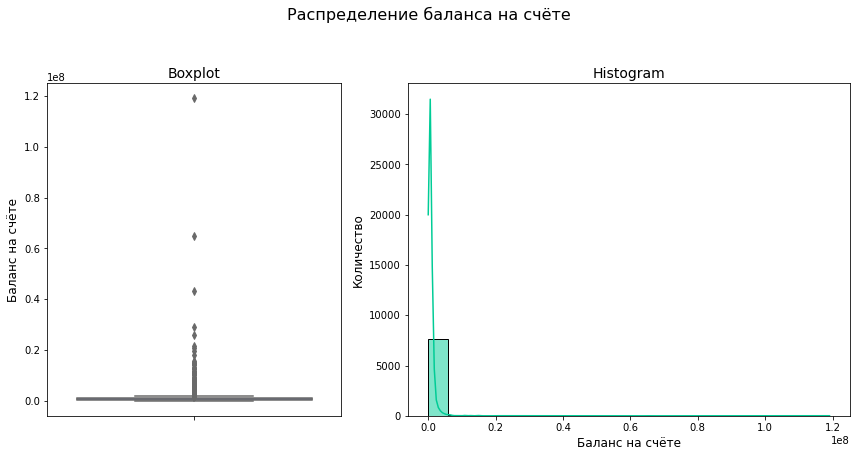

In [14]:
plot_var(df, 'balance', 'Распределение баланса на счёте', 'Баланс на счёте')

В балансе клиентов есть сильные выбросы, отбросим людей с более 2 миллионами на счете. 

In [15]:
df_new = df[(df['balance'] < 2000000) | (df['balance'].isna())]
df_shape_new = df_new.shape[0]
print('Доля оставшихся после удаления данных: ', round(df_shape_new/df_shape * 100,2))

Доля оставшихся после удаления данных:  95.7


Количество отброшенных данных не превышает 10%

In [16]:
df = df_new

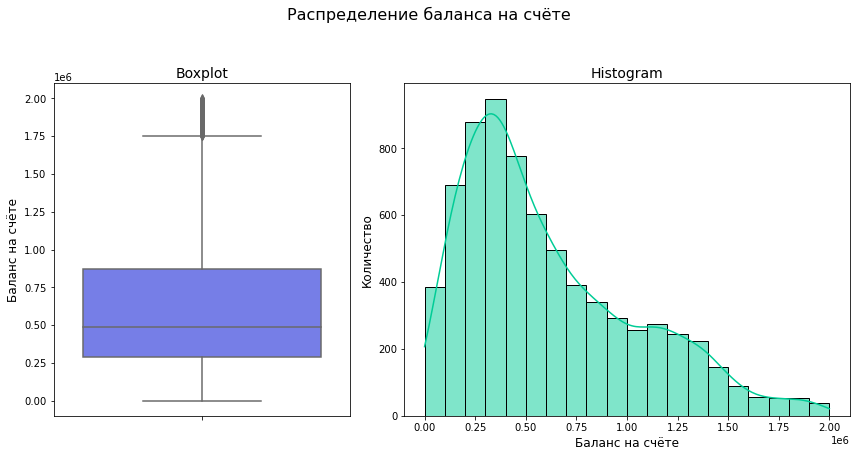

In [17]:
plot_var(df, 'balance', 'Распределение баланса на счёте', 'Баланс на счёте')

<div class="alert alert-info"> Медианное значение баланса - 489К. Большинство клиентов имеет баланс от 286К до 872К. Количество людей с балансом более 1.75М достаточно маленькое, но удалять их не будем.

##### 1.2 Распределение зарплаты

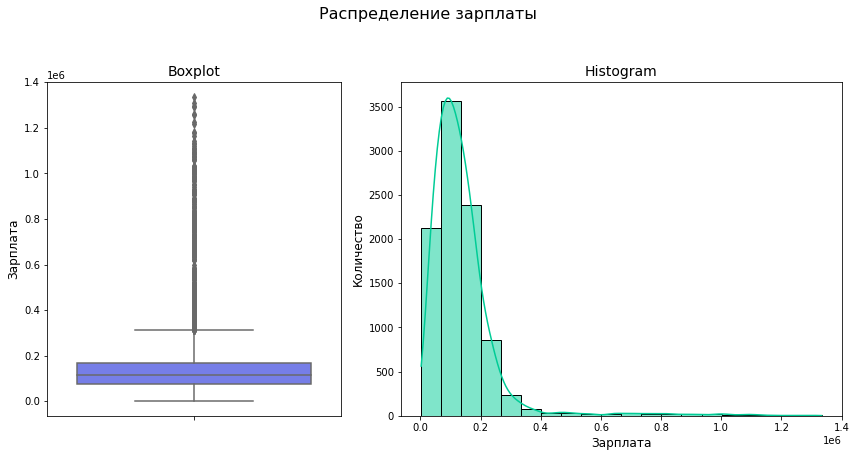

In [18]:
plot_var(df, 'salary', 'Распределение зарплаты', 'Зарплата')

Распределение зарпалаты также неравномерно. Может удалить некоторые выбросы: клиентов с зарплатой больше 500 тысяч.

In [19]:
df_new = df[(df['salary'] <= 500000) | (df['salary'].isna())]
df_shape_new = df_new.shape[0]
print('Доля оставшихся после удаления данных: ', round(df_shape_new/df_shape * 100,2))

Доля оставшихся после удаления данных:  93.68


Количество отброшенных данных не превышает 10%

In [20]:
df = df_new

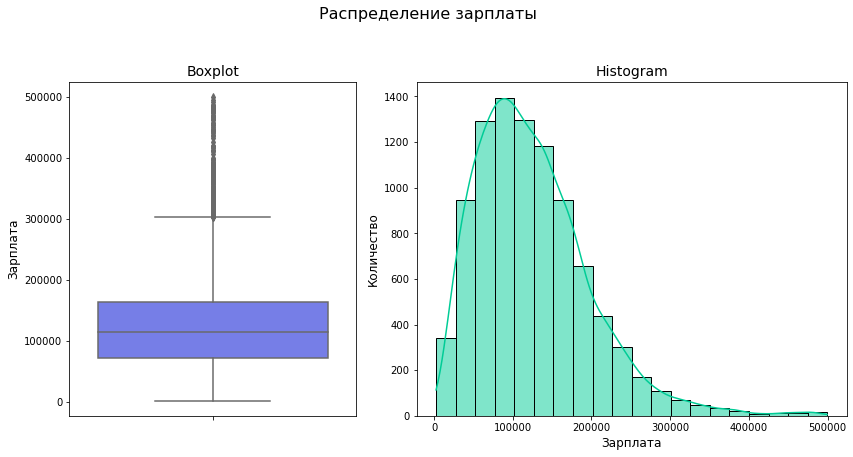

In [21]:
plot_var(df, 'salary', 'Распределение зарплаты', 'Зарплата')

<div class="alert alert-info"> Выбросы все еще есть, но пока оставим их. Медианная зарплата около 115К. Большинство клиентов имеют зарплату от 73К до 165К.

##### 1.3 Распределение баллов кредитного скоринга

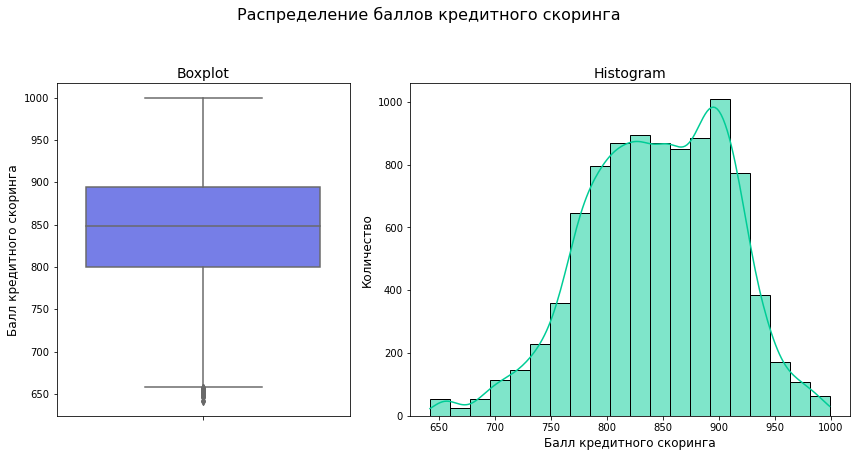

In [22]:
plot_var(df, 'score', 'Распределение баллов кредитного скоринга', 'Балл кредитного скоринга')

<div class="alert alert-info">Распределение баллов кредитного скоринга близко к нормальному, есть небольшие выбросы: несколько пользователей с баллами ниже 657. Медиана - 848. Большинство пользователей имеею рейтинг от 800 до 895.

##### 1.4 Распределение возраста

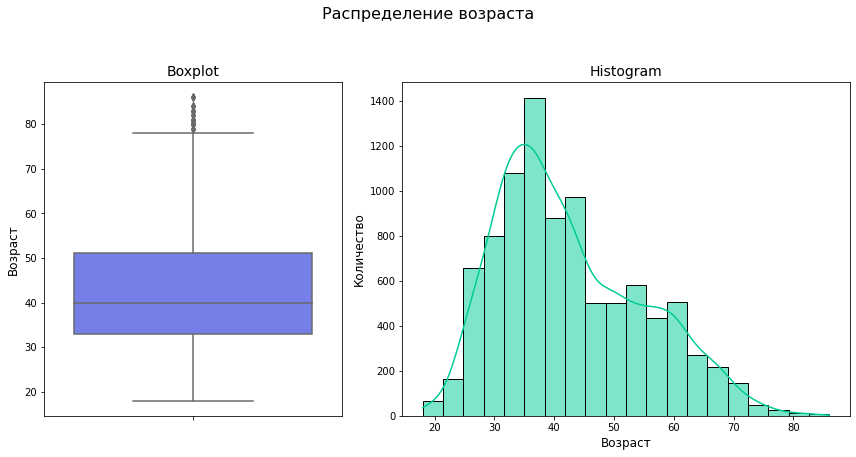

In [23]:
plot_var(df, 'age', 'Распределение возраста', 'Возраст')

<div class="alert alert-info">Большинству клиентов 33-51 год, а медианный возраст - 40 лет. Есть небольшое количество людей, старше 78 лет. 

##### 1.5 Распределение количества баллов собственности

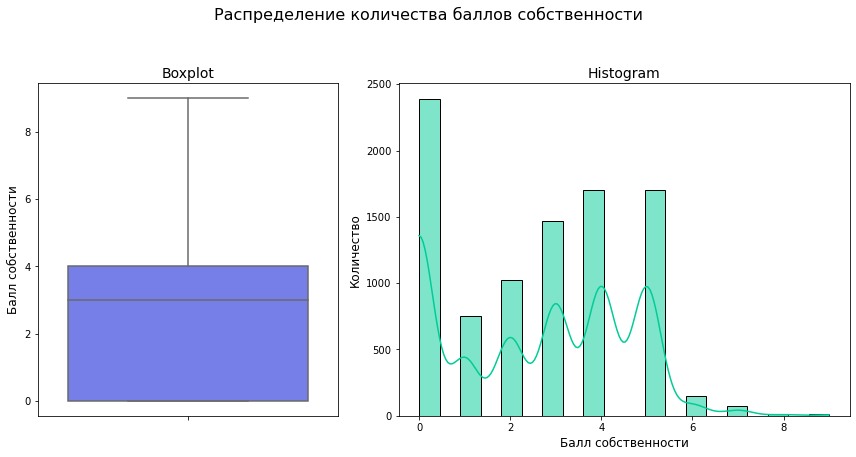

In [24]:
plot_var(df, 'equity', 'Распределение количества баллов собственности', 'Балл собственности')

<div class="alert alert-info">Большинство клиентов имеют 0 баллов собственности, также большое количество имеют 4 и 5 балла. Выше 5 уже совсем малое количество. Медиана - 3 балла.

##### 1.6 Распределение количества продуктов, которыми пользуется клиент

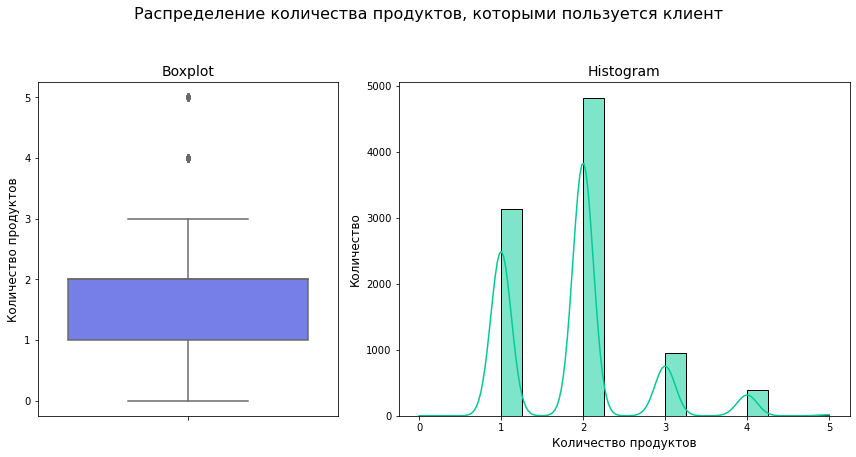

In [25]:
plot_var(df, 'products', 'Распределение количества продуктов, которыми пользуется клиент', 'Количество продуктов')

<div class="alert alert-info">Большинство клиентов пользуются 2 продуктами банка, и только 19 человек пользуются 5 продуктами, что является максимальным количеством продуктов. Ноль продуктов всего у нескольких клиентов.

##### 1.7 Распределение клиентов по городам

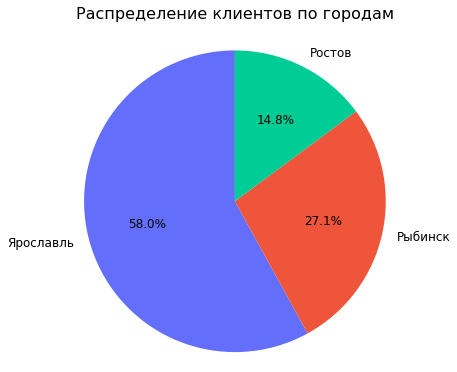

In [26]:
city_counts = df['city'].value_counts().reset_index()
city_counts.columns = ['city', 'count']

plt.figure(figsize=(6, 6))
plt.pie(city_counts['count'], 
        labels=city_counts['city'], 
        autopct='%1.1f%%',  
        startangle=90, 
        colors=colors, 
        textprops={'fontsize': 12, 'color': 'black'})
plt.title('Распределение клиентов по городам', fontsize=16, pad=20)
plt.axis('equal')  
plt.show()

<div class="alert alert-info"> Больше всего клиентов в Ярославле, меньше всего в Ростове.

##### 1.8 Распределение клиентов по полу

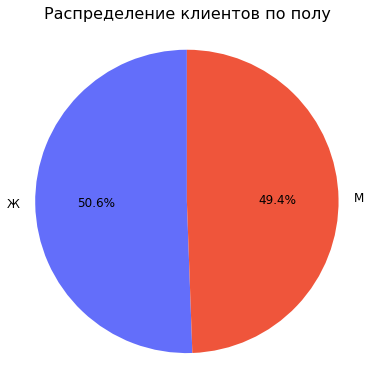

In [27]:
gender_counts = df['gender'].value_counts().reset_index()
gender_counts.columns = ['gender', 'count']

plt.figure(figsize=(6, 6))
plt.pie(
    gender_counts['count'], 
    labels=gender_counts['gender'], 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors, 
    textprops={'fontsize': 12, 'color': 'black'})
plt.title('Распределение клиентов по полу', fontsize=16, pad=20)
plt.axis('equal')
plt.show()

<div class="alert alert-info">Количество мужчин и женщин среди клиентов примерно одинаково (мужчин совсем немного меньше).

##### 1.9 Распределение клиентов по наличию кредитной карты

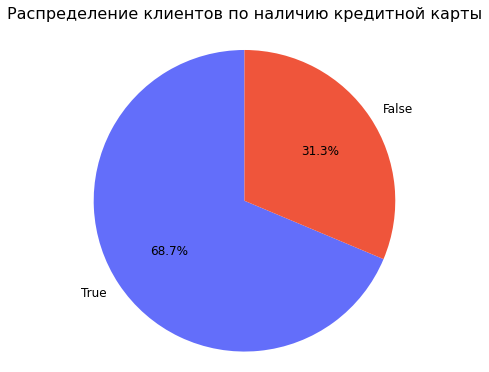

In [28]:
city_counts = df['credit_card'].value_counts().reset_index()
city_counts.columns = ['credit_card', 'count']

plt.figure(figsize=(6, 6))
plt.pie(
    city_counts['count'], 
    labels=city_counts['credit_card'], 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors, 
    textprops={'fontsize': 12, 'color': 'black'})
plt.title('Распределение клиентов по наличию кредитной карты', fontsize=16, pad=20)
plt.axis('equal')
plt.show()

<div class="alert alert-info"> Кредитной картой владеют в два раза больше клиентов.

##### 1.10 Распределение клиентов по активности

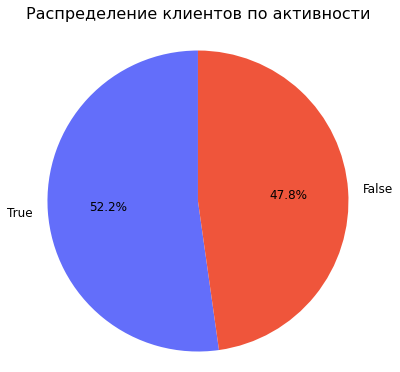

In [29]:
city_counts = df['last_activity'].value_counts().reset_index()
city_counts.columns = ['last_activity', 'count']

plt.figure(figsize=(6, 6))
plt.pie(
    city_counts['count'], 
    labels=city_counts['last_activity'], 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors, 
    textprops={'fontsize': 12, 'color': 'black'})
plt.title('Распределение клиентов по активности', fontsize=16, pad=20)
plt.axis('equal')
plt.show()

<div class="alert alert-info"> По активности клиенты распределены почти одинаково (чуть больше активных клиентов).

<div class="alert alert-info"> <b>Вывод</b>: Еще раз посмотрим на медианные значения по переменным:
        
- баланс на счету: 489K,
- зарплата: 115K,
- возраст: 40 лет, 
- баллы кредитного скоринга: 848 баллов,
- баллы собственности: 3,
- количество продуктов: 2. 
    
Также стоит отметить, что:

- больше всего пользователей в Ярославле; 
- количество женщин и мужчин среди клиентов примерно одинаково; 
- у большинства есть кредитная карта; 
- примерно одинаковое количество активных и неактивных пользователей.

#### 2. Построим портреты клиентов (разделив на группы ушли/не ушли)

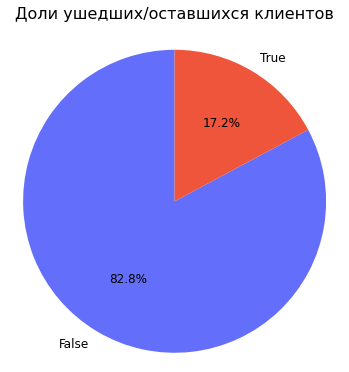

In [30]:
churn_counts = df['churn'].value_counts().reset_index()
churn_counts.columns = ['churn', 'count']

plt.figure(figsize=(6, 6))
plt.pie(
    churn_counts['count'], 
    labels=churn_counts['churn'], 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors, 
    textprops={'fontsize': 12, 'color': 'black'})
plt.title('Доли ушедших/оставшихся клиентов', fontsize=16, pad=20)
plt.axis('equal')
plt.show()

<div class="alert alert-info"> Доля ушедших клиентов составляет 17.2%, что является достаточно большой частью - почти одна пятая часть от всех клиентов.

In [31]:
df_leave = df[df['churn'] == True]
df_stay = df[df['churn'] == False]

##### 1.1 Распределение баллов кредитного скоринга

In [32]:
def leave_stay_plot(var, name, name2):
    mean_leave = df_leave[var].mean()
    mean_stay = df_stay[var].mean()
    print('Среднее значение у оставшихся клиентов:', round(mean_stay))
    print('Среднее значение у ушедших клиентов:', round(mean_leave))

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=var, hue='churn', multiple='stack', kde=False, palette=colors[:2])
    
    plt.title('Распределение ' + name, fontsize=16, pad=15)
    plt.xlabel(name2, fontsize=14)
    plt.ylabel('Количество клиентов', fontsize=14)
    plt.legend(title='Ушел ли клиент', labels=['Остался', 'Ушел'])
    plt.show()

Среднее значение у оставшихся клиентов: 843
Среднее значение у ушедших клиентов: 856


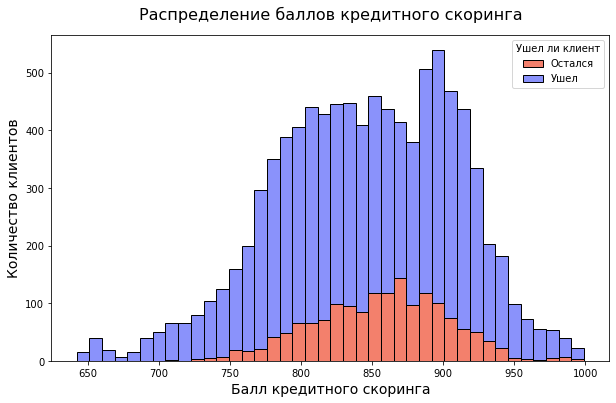

In [33]:
leave_stay_plot('score', 'баллов кредитного скоринга', 'Балл кредитного скоринга')

<div class="alert alert-info"> Среди оставшихся клиентов средний балл ниже, чем среди тех, что ушел (примерно на 13 баллов).

##### 1.2 Распределение возраста

Среднее значение у оставшихся клиентов: 43
Среднее значение у ушедших клиентов: 41


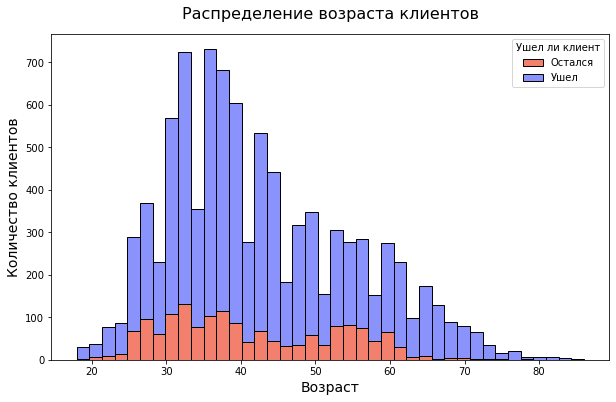

In [34]:
leave_stay_plot('age', 'возраста клиентов', 'Возраст')

<div class="alert alert-info"> Распределение возраста ушедших и оставшихся клиентов очень схоже. Среди оставшихся клиентов есть более пожилые люди (макс возраст больше).

##### 1.3 Распределение баллов собственности

Среднее значение у оставшихся клиентов: 2
Среднее значение у ушедших клиентов: 4


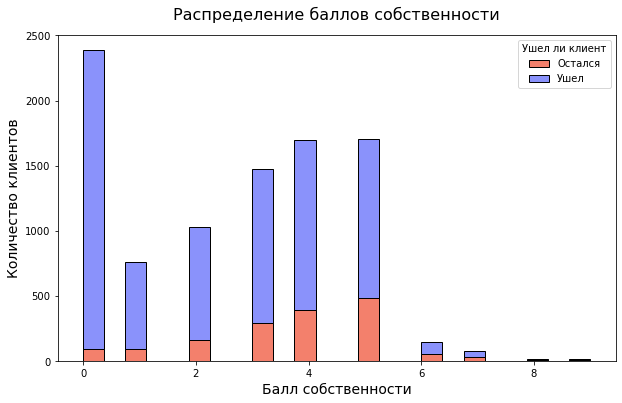

In [35]:
leave_stay_plot('equity', 'баллов собственности', 'Балл собственности')

<div class="alert alert-info"> Количество клиентов с нулем баллов собственности среди ушедших сильно ниже, чем среди тех, кто остался.

##### 1.4 Распределение баланса на счете

Среднее значение у оставшихся клиентов: 569863
Среднее значение у ушедших клиентов: 764171


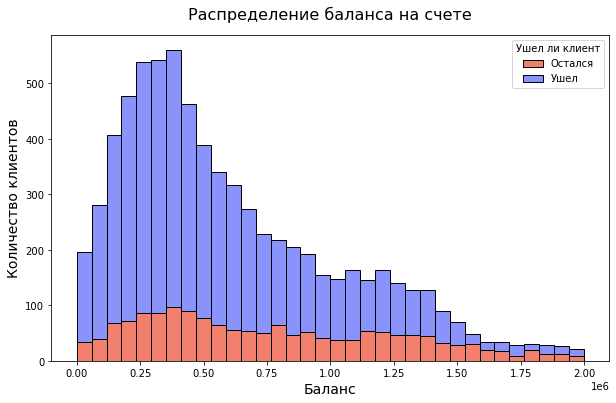

In [36]:
leave_stay_plot('balance', 'баланса на счете', 'Баланс')

<div class="alert alert-info"> Баланс счета ушедших клиентов в среднем на 200K больше, чем у оставшихся. 

##### 1.5 Распределение количества продуктов

Среднее значение у оставшихся клиентов: 2
Среднее значение у ушедших клиентов: 2


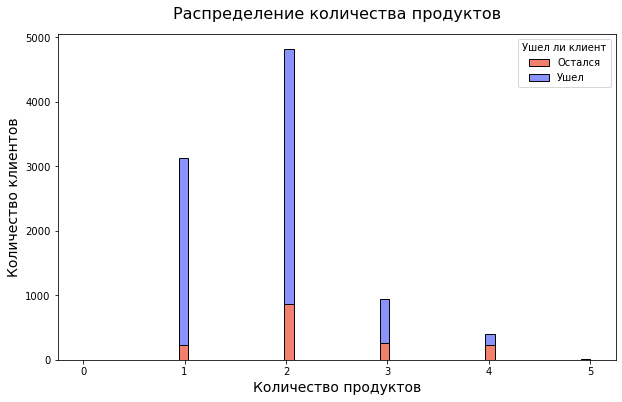

In [37]:
leave_stay_plot('products', 'количества продуктов', 'Количество продуктов')

<div class="alert alert-info"> Распределение количества продуктов в целом схоже, но среди оставшихся нет клиентов с 0 продуктов и намного больше людей с 1-2 продуктами.

##### 1.6 Распределение зарплаты

Среднее значение у оставшихся клиентов: 125714
Среднее значение у ушедших клиентов: 124264


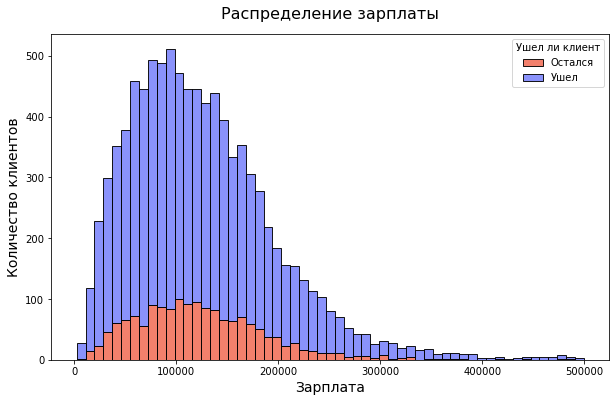

In [38]:
leave_stay_plot('salary', 'зарплаты', 'Зарплата')

<div class="alert alert-info"> Распределение зарплаты очень схоже.

##### 1.7 Распределение по городам

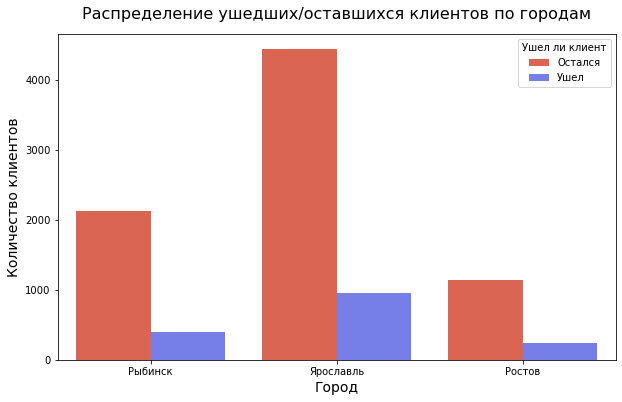

In [39]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='city', hue='churn', palette=colors[1::-1])

plt.title('Распределение ушедших/оставшихся клиентов по городам', fontsize=16, pad=15)
plt.xlabel('Город', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.legend(title='Ушел ли клиент', labels=['Остался', 'Ушел'])
plt.show()

<div class="alert alert-info"> Распределение по городам тоже похоже. Больше всего клиентов в городе Ярославль, меньше всего в Ростове.

##### 1.8 Распределение по полу

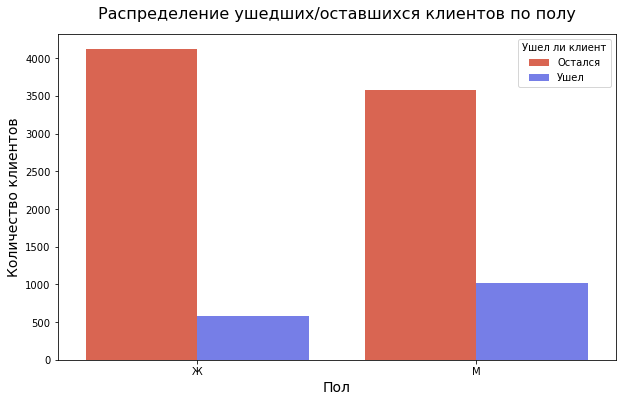

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='gender', hue='churn', palette=colors[1::-1])

plt.title('Распределение ушедших/оставшихся клиентов по полу', fontsize=16, pad=15)
plt.xlabel('Пол', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.legend(title='Ушел ли клиент', labels=['Остался', 'Ушел'])
plt.show()

<div class="alert alert-info">Среди ушедших клиентов больше мужчин.

##### 1.9 Распределение по наличию кредитной карты

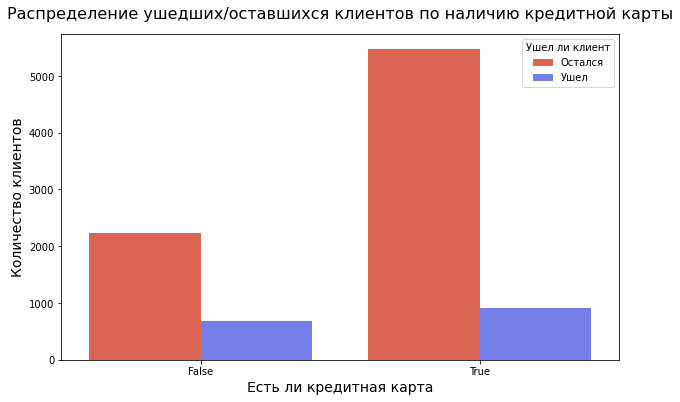

In [41]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='credit_card', hue='churn', palette=colors[1::-1])

plt.title('Распределение ушедших/оставшихся клиентов по наличию кредитной карты', fontsize=16, pad=15)
plt.xlabel('Есть ли кредитная карта', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.legend(title='Ушел ли клиент', labels=['Остался', 'Ушел'])
plt.show()

<div class="alert alert-info"> В сравнении с оставшимися клиентами, у ушедших клиентов примерно одинаковое количество людей с кредитной картой и без (немного больше с картой). В то время как у оставшихся намного больше людей имеют кредитную карту. 

##### 1.10 Распределение активных клиентов

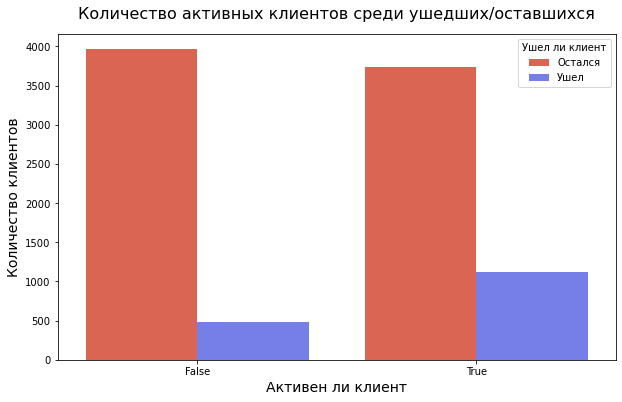

In [42]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='last_activity', hue='churn', palette=colors[1::-1])

plt.title('Количество активных клиентов среди ушедших/оставшихся', fontsize=16, pad=15)
plt.xlabel('Активен ли клиент', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.legend(title='Ушел ли клиент', labels=['Остался', 'Ушел'])
plt.show()

<div class="alert alert-info"> Среди ушедших клиентов больше активных, в то время как среди оставшихся - неактивных.

<div class="alert alert-info"> <b>Вывод</b>: Доля ушедших клиетов составляет около пятой части всех клиентов. Если говорить о ключевых различиях между ушедшими и оставшимися клиентами, стоит отметить:

- Балл кредитного скоринга ушедших клиентов в среднем на 13 выше, чем у тех, кто остался.
- Среди оставшихся клиентов больше людей пожилого возраста. 
- Количество клиентов с 0 баллов собственности среди ушедших сильно ниже, чем среди тех, кто остался.
- Баланса счета ушедших клиентов в среднем на 200K больше, чем у оставшихся.
- Среди оставшихся нет клиентов с 0 продуктов и намного больше людей с 1-2 продуктами.
- Зарплата почти одинакова.
- Среди тех, кто ушел, больше мужчин.
- Среди тех клиентов, кто имеет кредитную карту, меньше процент ухода.
- Среди ушедших клиентов больше активных.

#### 3. Проведем корреляционный анализ

In [43]:
correlation = df_dummies.corr()['churn'].drop(['churn','user_id']).sort_values(ascending=False)
correlation

products         0.301291
equity           0.270115
last_activity    0.169459
gender_М         0.141601
score            0.106383
balance          0.085708
salary           0.001392
age             -0.049748
credit_card     -0.130564
Name: churn, dtype: float64

<div class="alert alert-info"> С переменной оттока сильной связи не наблюдается ни у одного показателя. Наиболее связанные показатели: количество продуктов, собственность и баланс. Они положительно влияют на отток. 

### Проверка гипотез

Будем использовать тест Манна-Уинти, так как он устойчив к аномальным значениям, что как раз необходимо в нашем случае, ведь в анализируемых переменных присутствуют выбросы.

#### 1. Гипотеза "Средний доход тех клиентов, которые ушли и тех, которые остались, одинаков"

H0: Средний доход клиентов, которые ушли, равен среднему доходу клиентов, которые остались.
<br>H1: Средний доход клиентов, которые ушли, не равен среднему доходу клиентов, которые остались.

In [44]:
churn_true = df_leave['salary']
churn_false = df_stay['salary']

statistic, p_value = stats.mannwhitneyu(churn_true, churn_false)

print("Statistic:", statistic)
print("p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: средние доходы различаются.")
else:
    print("Не можем отвергнуть нулевую гипотезу: средние доходы не различаются.")

Statistic: 6239593.0
p-value: 0.35044578632367984
Не можем отвергнуть нулевую гипотезу: средние доходы не различаются.


<div class="alert alert-info">Тест показал, что средние доходы тех, кто ушел, и тех, кто остался, не различаются.

#### 2. Гипотеза "Средний балл кредитного скоринга тех клиентов, которые ушли и тех, которые остались, одинаков"

H0: Средний балл кредитного скоринга клиентов, которые ушли, равен среднему баллу клиентов, которые остались.
<br>H1: Средний балл кредитного скоринга клиентов, которые ушли, не равен среднему баллу клиентов, которые остались.

In [45]:
churn_true = df_leave['score']
churn_false = df_stay['score']

statistic, p_value = stats.mannwhitneyu(churn_true, churn_false)

print("Statistic:", statistic)
print("p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: средний балл кредитного скоринга различается.")
else:
    print("Не можем отвергнуть нулевую гипотезу: средний балл кредитного скоринга не различается.")

Statistic: 6789708.0
p-value: 5.046730822225727e-11
Отвергаем нулевую гипотезу: средний балл кредитного скоринга различается.


<div class="alert alert-info"> Тест показал, что средний балл кредитного скоринга тех, кто ушел, и тех, кто остался, различается.

#### 3. Гипотеза "Средний возраст тех клиентов, которые ушли и тех, которые остались, одинаков"

H0: Средний возраст клиентов, которые ушли, равен среднему возраст клиентов, которые остались.
<br>H1: Средний возраст клиентов, которые ушли, не равен среднему возраст клиентов, которые остались.

In [46]:
churn_true = df_leave['age']
churn_false = df_stay['age']

statistic, p_value = stats.mannwhitneyu(churn_true, churn_false)

print("Statistic:", statistic)
print("p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: средний возраст различается.")
else:
    print("Не можем отвергнуть нулевую гипотезу: средний возраст не различается.")

Statistic: 5709629.5
p-value: 6.883927194597237e-06
Отвергаем нулевую гипотезу: средний возраст различается.


<div class="alert alert-info">Тест показал, что средний возраст тех, кто ушел, и тех, кто остался, различается.

<div class="alert alert-info"><b>Вывод</b>: средний доход среди оставшихся и ушедших клиентов не различается, а средний балл кредитного скоринга и средний возраст отличаются.

### Сегментация данных

<div class="alert alert-info">Из построенных портретов клиентов мы выяснили, что наиболее значимыми показателями являются: количество продуктов, собственность, баланс, пол, наличие кредитной карты и активность. Балл кредитного скоринга и возраст также различаются среди ушедших и оставшихся клиентов.

На основе имеющихся различий разделим клиентов на 3 сегмента.

#### 1. Разделим клиентов на сегменты

In [47]:
def segments(segment):
    shape = segment.shape[0]
    shape_leave = segment[segment['churn'] == True].shape[0]
    
    print('Количество клиентов в сегменте:', shape)
    print('Количество отточных клиентов в сегменте:', shape_leave)
    print(f'Уровень оттока: {round((shape_leave/shape)*100)}%')

##### Сегмент 1: Молодые клиенты с высоким балансом и без кредитной карты

In [48]:
segment_1 = df[(df['age'] <= 35) &
               (df['balance'] >= 500000) &
               (df['credit_card'] == False)]
segments(segment_1)

Количество клиентов в сегменте: 347
Количество отточных клиентов в сегменте: 175
Уровень оттока: 50%


<div class="alert alert-info">В сегменте 1 очень большой уровень оттока (50%). Однако если изменить наличие кредитной карты (предположим, теперь эти клиенты имеют кредитную карту) уровень оттока снизится до 29%.

##### Сегмент 2: Мужчины с высоким уровнем собственности, высоким балансом и без кредитной карты

In [49]:
segment_2 = df[(df['gender'] == 'М') &
               (df['equity'] >= 3) &
               (df['balance'] >= 500000) &
               (df['credit_card'] == False)]
segments(segment_2)

Количество клиентов в сегменте: 525
Количество отточных клиентов в сегменте: 271
Уровень оттока: 52%


<div class="alert alert-info">Для сегмента 2 получаются похожие выводы, процент оттока клиентов без кредитной карты высок (52%), а с картой заметно ниже (30%).

##### Сегмент 3: Активные клиенты с высоким кредитным скорингом, низким количеством продуктов и кредитной картой

In [50]:
segment_3 = df[(df['score'] >= 900) &
               (df['products'] <= 2) &
               (df['credit_card'] == False) &
               (df['last_activity'] == True)]
segments(segment_3)

Количество клиентов в сегменте: 246
Количество отточных клиентов в сегменте: 75
Уровень оттока: 30%


<div class="alert alert-info"> В сегменте 3 уровень оттока ниже остальных (30%) и при изменение на "кредитная карта есть" становиться даже ниже, чем общий отток по банку.

#### 2. Приоритизируем сегменты

<div class="alert alert-info"> Из 3 сегментов наиболее приоритетным кажется <b>2 сегмент</b>, так как объем выборки, а также уровень оттока в нем самые большие. Однако не стоит забывать про возраст: он тоже сильно влияет на уход клиентов (молодые люди уходят чаще).

<div class="alert alert-info"> <b>Вывод:</b> основными признаками, влиящими на отток, являются возраст и наличие кредитной карты. Также влияет пол: мужчины склонны уходить чаще. Рейтинг кредитного скоринга и количество продуктов не так сильно отражаются на уходе клиентов.

### Рекомендации

<div class="alert alert-info">Основными группами клиентов, на которые стоит обратить внимание банку, являются молодые люди, чаще мужского пола. Также зачастую они имеют высокий баланс и балл собственности. 

Важно отметить, что наличие кредитной карты сильно снижает процент оттока среди всех клиентов, поэтому банку следует продвигать этот вид своих продуктов. 

На отток сильно влияет активность клиентов: активные клиенты уходят чаще. Возможно это связано с тем, что клиенты были неудовлетворены своими последними действиями с банком и поэтому решили уйти, или же они, уже приняв решение уйти, осуществляли действия по закрытию своих вкладов/счетов перед уходом. Однако в этом случае, повлиять на этот показатель банку будет сложно. 